Easton Potokar

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import mne                               #package to handle EEG data files
import os, seaborn, re, pywt
from scipy import io                     #for loading matlab file
from scipy import fftpack                #for Fourier Transform Analysis
from helpers import *                    #py file full of helper functions

import warnings
warnings.filterwarnings("ignore", module="pandas") #disable some pandas plotting erros

plt.style.use("seaborn")
plt.rcParams["figure.dpi"] = 300

fs = 256                                 #sample size

# Introduction

Neonatal seizures are a common occurrence and require immediate care. Detection is only possible through continuous electroencephalogram (EEG) monitoring. Unfortunately, this places a heavy burden on NICUs (Newborn Intensive Care Units) due to the expertise needed to interpret EEGs that is generally not available in a NICU. Alternative options include a simplified easy-to-read trend of the EEG output known as an amplitude integrated EEG (aEEG). While it has its strengths, drawbacks include short duration and low amplitude of seizures, causing them to be missed entirely. 

Continuous multichannel EEG is the gold standard for detecting seizures but expert interpretation is not readily available to NICUs. Alternatives include providing experts remote access to the EEG, but this still requires 24-
hour surveillance, also a heavy load.

The dataset that will be used is available through a public repository containing EEG recordings of 79 term neonates admitted to the NICU, with a meidan duration of 74 minutes available at https://zenodo.org/record/2547147. Each EEG recording includes 21 channels of data, each recorded at 256Hz, thus containing frequencies up to 128HZ. These recordings were examined by three experts with their labelings of either a seizure being present or not being present included at second intervals. Along with each of these neonates is clinical information about them, including body weight in grams, gestational age, and postmenstrual age. 

Much research has been done on developing algorithmns to identify seizures in adult patients, but little has been done to identify them in prematue and full term infants.

Questions looking to be answered by this dataset include, but are not limited to: Is there a correlation between BW/GA and frequency of seizures? Is it more prevental in males or females? Are there certain frequencies in the EEG data where seizures occur? Do certain channels in the EEG recordings correlate more with seizures than others?

# Data Preparation
## Data Scraping

The data can be found at [2], and is best downloaded using the python package `zenodo-get`. Running `pip install zenodo-get` followed by `zenodo_get.py 10.5281/zenodo.2547147` downloads all data and checks the md5sums to ensure everything downloaded properly. Since this process was simple enough, no additional scraping methods were needed.

## Data Cleaning

### Cleaning Clinical Information

The data is stored in a mixture of `.csv`, `.mat`, and `.edf` files. The `.edf` files are the standard for EEG data and can be read using the python package `mne`. First, we load the `.csv` files into a pandas dataframe and clean the data found in them. We load the location of the corresponding EEG file, the ID of the infant (index from 1 to 79), the gender, gestional age (GA) in weeks, the post menstrual age (PMA) at time of EEG recording in weeks, and the body weight (BW) in grams. GA refers to week when born since conception and PMA is current week since conception. 

In addition, 22 of the neonates don't have any expert reviews, so we drop those rows, bringing the total to 57. We replace both the strings in BW, GA, and PMA with floats at the center of their intervals. Since the intervals hold value with respect to each other (i.e., one interval is definitely larger than another), it is hoped this will aid in analysis. Further, any N/A features are replaced with the mean of other infants containing other similar features. The expert analysis is also loaded in from the `.mat` file and saved as a column in the pandas dataframe.

In [2]:
#load in clinical data
ci = pd.read_csv("data-og/clinical_information.csv", index_col="ID", usecols=["EEG file", "ID", "Gender", "GA (weeks)", "BW (g)", "EEG to PMA (weeks)", "Number of Reviewers Annotating Seizure"])

#drop rows without expert annotations
ci = ci[ ci["Number of Reviewers Annotating Seizure"] != 0]

#replace weight string values with middle of interval
replaceBW = {"less than 2500g": 2250,
              "2500 to 3000g": 2750,
              "3000 to 3500g": 3250,
              "3500 to 4000g": 3750,
              "greater than 4000g": 4250,
              }
ci.replace(replaceBW, inplace=True)

#replace GA/PMA string values with middle of interval
def interval(weeks):
    if not isinstance(weeks, str) and np.isnan(weeks):
        return weeks
    values = re.compile(r"(\d{2})").findall(weeks)
    return (float(values[0]) + float(values[1])) / 2
ci['GA (weeks)'] = ci['GA (weeks)'].apply(interval)
ci['EEG to PMA (weeks)'] = ci['EEG to PMA (weeks)'].apply(interval)

#replace NaN values with something useful
#Both in the GA column
missing_idx = pd.isna(ci["GA (weeks)"])
for index, row in ci.loc[missing_idx].iterrows():
    similar = ci['EEG to PMA (weeks)'] == ci.loc[index, 'EEG to PMA (weeks)']
    ci.loc[index, 'GA (weeks)'] = ci.loc[similar, 'GA (weeks)'].mean()    
#and in the BW column
missing_idx = pd.isna(ci["BW (g)"])
for index, row in ci.loc[missing_idx].iterrows():
    similar = ci['GA (weeks)'] == ci.loc[index, 'GA (weeks)']
    ci.loc[index, 'BW (g)'] = ci.loc[similar, 'BW (g)'].mean() 
#there is a single missing m/f. Replace with the mode
missing_idx = pd.isna(ci["Gender"])
for index, row in ci.loc[missing_idx].iterrows():
    ci.loc[index, 'Gender'] = ci['Gender'].mode()[0]

#load in all experts analysis from .mat file. Note we save as a numpy array b/c each child has a different length of recording
annot = io.loadmat('data-og/annotations_2017.mat')['annotat_new']
ci['expertA'] = [annot[0,i-1][0,:] for i in ci.index]
ci['expertB'] = [annot[0,i-1][1,:] for i in ci.index]
ci['expertC'] = [annot[0,i-1][2,:] for i in ci.index]

#visualize a couple of rows to see how it looks
ci.sample(3)

,EEG file,Gender,BW (g),GA (weeks),EEG to PMA (weeks),Number of Reviewers Annotating Seizure,expertA,expertB,expertC
ID,,,,,,,,,
41,eeg41,f,2750.0,37.5,38.5,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
33,eeg33,m,3250.0,36.5,37.5,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
78,eeg78,f,3750.0,41.5,41.5,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Cleaning EEG Data

Next, we use `mne` to read all data into a pandas DataFrame. The corresponding info, like the BW; GA; PMA; etc., is saved as metadata on each seperate dataFrame and then saved as a pickle file for later analysis since each file is too large to be opened simultaneously. Further, we check to ensure that the experts' analyses length correctly matches the EEG recordings and we relabel the EEG recording's channels to all match. 

In [ ]:
#iterate through all of files
for i in ci.index:
    #read in all of the raw data
    raw = mne.io.read_raw_edf("data-og/{}.edf".format(ci["EEG file"][i]))
    channels = raw.ch_names
    signals = raw[channels][0] * 10**6
    time = raw[0,:][1]

    #clean channel names
    for k, chan in enumerate(channels):
        #if it contains -REF at end
        try:
            channels[k] = re.compile(r"\s(\w*?)-").findall(chan)[0]
        #otherwise take first word
        except:
            channels[k] = re.compile(r"\s(\w.*)").findall(chan)[0]
        #relabel to things I like better
        if channels[k] == "Effort":
            channels[k] = "Resp Effort"
        if channels[k] == "EKG":
            channels[k] = "ECG EKG"
    
    #check to make sure there's no duplicate channels
    if len(set(channels)) != len(channels):
        raise ValueError("Channel has non unique data")
    #check to make sure has the same channels as the previous one
    if i == 1:
        chan_prev = channels
    else:
        if set(channels) != set(chan_prev):
            raise ValueError("EEGs have different channels")
        chan_prev = channels
    
    #save into pandas DataFrame
    df = pd.DataFrame(signals.T, columns=channels, index=time)
    
    #also upsample expert analysis with forward fill and save with it
    def upsample(low_res, high_res, name):
        low_res = pd.Series(low_res, np.arange(len(low_res)))
        temp = low_res.reindex(high_res.index, method='ffill')
        high_res[name] = temp
    upsample(ci.loc[i, 'expertA'], df, 'expertA')
    upsample(ci.loc[i, 'expertB'], df, 'expertB')
    upsample(ci.loc[i, 'expertC'], df, 'expertC')
    
    #check to make sure all experts analyzed correctly sized data
    if len(ci['expertA'][i]) != len(df.index) / 256:
        print(len(ci['expertA'][i]), len(df.index) / 256)
        raise ValueError("EEG {} has mismatched expert A and time stamps")
    if len(ci['expertB'][i]) != len(df.index) / 256:
        print(len(ci['expertB'][i]), len(df.index) / 256)
        raise ValueError("EEG {} has mismatched expert B and time stamps")
    if len(ci['expertC'][i]) != len(df.index) / 256:
        print(len(ci['expertC'][i]), len(df.index) / 256)
        raise ValueError("EEG {} has mismatched expert C and time stamps")
        
    #save to pickle file and update location in ci
    print("Saving {} to pkl...".format(ci["EEG file"][i]))
    df.to_pickle('data-cleaned/{}.pkl'.format(ci["EEG file"][i]), protocol=-1)
    ci.loc[i, "EEG file"] = "data-cleaned/{}.pkl".format(ci.loc[i, "EEG file"])
    
ci.to_pickle('data-cleaned/ci.pkl', protocol=-1)

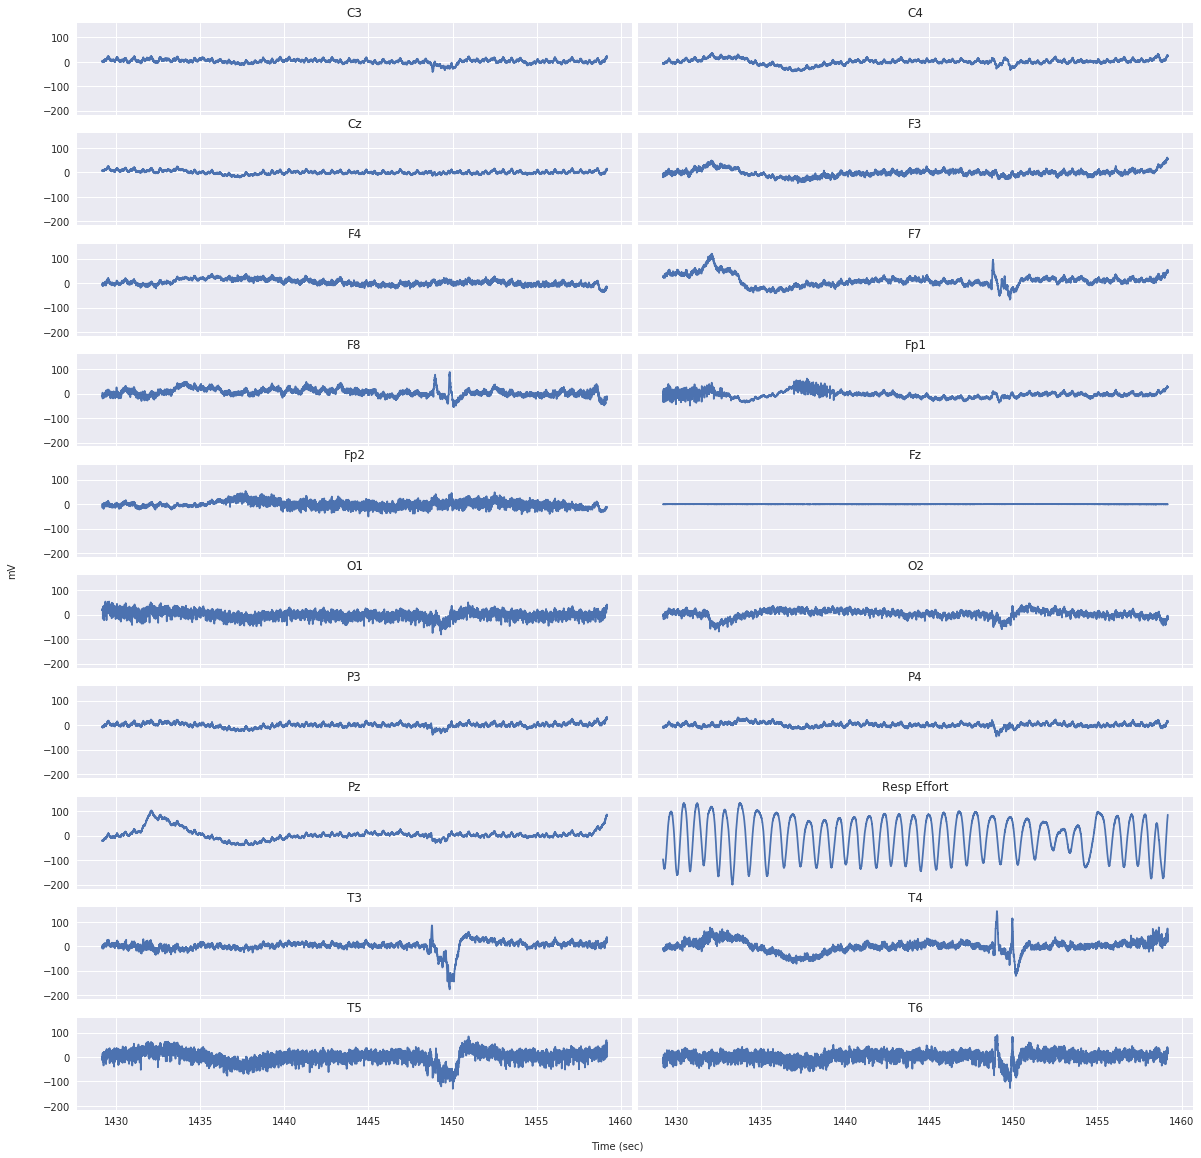

In [4]:
# we plot a random sample of 30 seconds from a random neonate
plot_signal(ci.loc[np.random.randint(1,79), 'EEG file'], channels=None, slices=30)

## Potential Data Problems

I believe the source of the data to be quite reliable. The data was recorded from a hospital in Finland by a third party, which removes any sort of bias or data picking. The group who posted it was also looking to implement different ML algorithmns to detect seizures and appeared to be at least moderately successful using an SVM. As long as the group didn't cherry-pick data for their model, which seems unlikely since that would be unethical and it's been published, the data should be sufficiently reliable.

Upon examining the data, I found that the length of recordings didn't match up with the length of some of the analyses by "Expert A", which obviously raises a lot of alarms. Upon further inspection, there appears to be something wrong with the `.csv` file containing Expert A's annotations. Fortunately, a `.mat` file was also included in the dataset and all the lengths match up for each expert and the EEG data. Beyond that, all clinical data appears to have valid information. While examining some of the EEG recordings, it appears that some channels are occaisonally mostly noise as well, but I could be mistaken. Further analysis will be done in the frequency domain during Feature Engineering.

# Feature Engineering

## Seizures

Here we split the EEG recordings into files of seizures and non-seizures. Note that we do this independently for each expert - thus giving us more data and also accounting somewhat for disrepenancy between them. If any experts have exactly the same seizure measured, then it will appear more than once, but this will only increase the strength of that data point.

In [ ]:
for i in ci.index:
    #read in data
    df = read_data(ci.loc[i, 'EEG file']) 
    
    #not every expert reviewed each infant - make sure we get all data possible
    corr_experts = ci.loc[i, "Number of Reviewers Annotating Seizure"]
    num_experts = 0
    
    #function to split + save things
    def split(expert):
        idx = df.iloc[:-1][expert].values - df.iloc[1:][expert].values
        idx = np.append(0, np.ma.nonzero(idx)[0]+1, len(df.index))
        for j in range(len(idx)-1):
            #get split we want
            temp = df.iloc[idx[j]:idx[j+1]].copy()
            #save metadata
            temp.ID = i
            temp.expert = expert[-1]
            temp.seizure = bool(temp[expert].iloc[0])
            temp._metadata = ['ID', 'expert', 'seizure']
            #drop expert analysis since it's not needed
            temp.drop(['expertA', 'expertB', 'expertC'], axis=1, inplace=True)
            #save
            temp.to_pickle(f'data-split/eeg{i}_{expert}_{j}.pkl', protocol=-1)
            
    #iterate through all experts to save things
    if np.sum(ci.loc[i, 'expertA']) != 0:
        num_experts += 1
        split('expertA')
    if np.sum(ci.loc[i, 'expertB']) != 0:
        num_experts += 1
        split('expertB')
    if np.sum(ci.loc[i, 'expertC']) != 0:
        num_experts += 1
        split('expertC')
        
    #check to make sure we got them all
    if num_experts != corr_experts:
        raise ValueError(f"Should be {corr_experts}, only {num_experts} have annotated anything")
    print(i, end=' ')

## Clinical Information

We also add features to the clinical data to analyze if any neonates were more at risk for seizures than others. We add average seizures for each expert and total average as well. We also one hot encode the gender column and add a recording length column.

In [13]:
#columns for length of recording
ci = read_data('data-cleaned/ci.pkl')
ci['seconds'] = [len(ci['expertA'][i]) for i in ci.index]

#make rows of expert averages
ci['expertA_avg'] = [np.sum(ci['expertA'][i]) / len(ci['expertA'][i]) for i in ci.index]
ci['expertB_avg'] = [np.sum(ci['expertB'][i]) / len(ci['expertB'][i]) for i in ci.index]
ci['expertC_avg'] = [np.sum(ci['expertC'][i]) / len(ci['expertC'][i]) for i in ci.index]

#make column of all expert averages
ci['expert_avg'] = (ci['expertA_avg'] + ci['expertB_avg'] + ci['expertC_avg']) / (ci["Number of Reviewers Annotating Seizure"])

#create hot encoded gender column
ci['Male'] = ( ci['Gender'] == "m" ).apply(int)

ci.to_pickle('data-final/ci.pkl', protocol=-1)

## Discrete Fourier and Wavelet Transform 

To analyze the EEG channels, we need a way to compress them into smaller, more indentifiable features. To this end, we investigate all channels both in the frequency domain and using wavelets. 

To calculate the frequency domain we use the FFT. This will result in frequency up to 128Hz since it was recorded at 256Hz. 

For the wavelet transform, we utilize Daubechies wavelets of order 2 with four levels of decomposition, resulting in four details (D1, D2, D3, D4) and one approximation (A4). This level of details has been shown to capture the frequencies found in EEG recordings [1] well, and the smooth features of Daubechies wavelets of order 2 capture changes in the data particularly well. 

In [51]:
def fft(df):
    N = len(df.index)
    freq = fftpack.fftfreq(N, 1/fs)
    data = fftpack.fft(df, axis=0)
    idx = freq > 0
    return pd.DataFrame(np.abs(data[idx]), columns=df.columns, index=freq[idx])

def wavelet(df, wave='db2', level=4):
    coeff = pywt.wavedec(df, wave, level=level, axis=0)
    return [pd.DataFrame(i, columns=data.columns) for i in coeff]

## Putting it all together

From both the wavelet and frequency transforms we calculate the 2-norm and entropy and normalize by length of recording, and also calculate the mean and standard deviation. For the wavelets, we also save the maximum and minimum value, and for frequency we save the maximum frequency along with it's value. This is done for each channel, resulting in $23*6*5$ features for wavelets, and $23*6$ features for frequency, resulting in 828 features. 

Using these features and the clinical information, we combine all the seizure/non-seizure data points into two dataframes (one for wavelets and one for frequencies) while extracting these features from the EEG recordings. 

In [ ]:
rows_list = []
num = '0'
ci = read_data('data-final/ci.pkl')
for subdir, dirs, files in os.walk("data-split/"):
    for file in files:
        if file[-3:] == "pkl":
            #load data
            data = read_data("data-split/" + file)
            
            #get clinical features and misc features
            dic = ci.loc[data.ID, ['BW (g)', 'GA (weeks)', 'EEG to PMA (weeks)', 'Male']]
            dic['Seconds'] = data.index[-1] - data.index[0]
            dic['Seizure'] = data.seizure
    
            #get Fourier and Wavelet transform
            data_fft = fft(data)
            A, D4, D3, D2, D1 = wavelet(data)
            features = [data_fft, A, D4, D3, D2, D1]
            
            #iterate through them all adding the features we need
            names = ["Freq", "A", "D4", "D3", "D2", "D1"]
            for feature, name in zip(features, names):
                mean     = feature.add_prefix(f"{name}_Mean_").mean()
                stdev    = feature.add_prefix(f"{name}_Stdev_").std()
                norm     = feature.add_prefix(f"{name}_2norm_")
                norm     = np.square(norm).sum(axis=0) / norm.index.size
                entropy  = feature.add_prefix(f"{name}_Entropy_")
                mask     = entropy != 0
                entropy  = (np.square(entropy[mask])*np.log(np.square(entropy[mask]))).sum(axis=0) / entropy.index.size
                dic      = {**dic, **mean.to_dict(), **stdev.to_dict(), **norm.to_dict(), **entropy.to_dict()}
            
            #do the same for wavelet only features
            for feature, name in zip(features[1:], names[1:]):
                maximum     = feature.add_prefix(f"{name}_Max_").max()
                minimum     = feature.add_prefix(f"{name}_Min_").min()
                dic         = {**dic, **maximum.to_dict(), **minimum.to_dict()}
                
            #do the same for frequency only features
            for feature, name in zip(features[0:1], names[0:1]):
                maximum     = feature.add_prefix(f"{name}_Max_").max()
                idxmax      = feature.add_prefix(f"{name}_IdxMax_").idxmax()
                dic      = {**dic, **maximum.to_dict(), **idxmax.to_dict()}
                
            rows_list.append( dic )
            
            if num != file[3:5]:
                num = file[3:5]
                print(num, end=' ')
            
df = pd.DataFrame(rows_list)
df.to_pickle('data-final/eeg.pkl', protocol=-1)

# Data Visualization

First, we compare clinical information to see if certain physical properties of neonates makes him/her more likely to have a high amount of seizures.

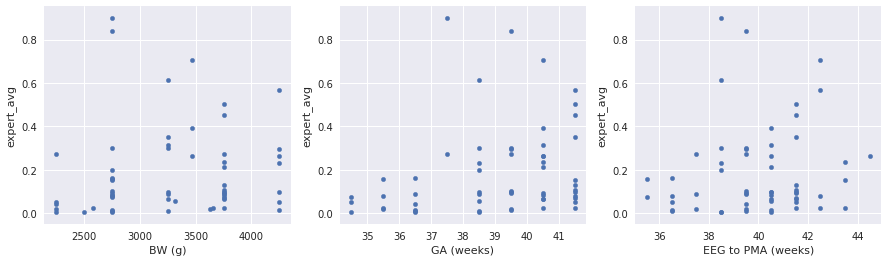

In [2]:
#read in all data
ci = read_data('data-final/ci.pkl')
df = read_data('data-final/eeg.pkl')

cols = ['BW (g)', 'GA (weeks)', 'EEG to PMA (weeks)']
fig, ax_new = plt.subplots(1,3, sharey=False, figsize=(15,4))
for ax, col in zip(ax_new, cols):
    ci.plot(kind='scatter', x=col, y='expert_avg', ax=ax, legend=None)

Notice this shows that there is a decent correlation between GA and PMA and the percent of seizures. Being older doesn't necessarily mean the neonate will definitely have seizures, but perhaps it makes it possible to have more frequent seizures due to a more developed brain. We are decently undersampled here, though, and it could just be due to random variation.

Similiarly, we analyze gender to see if it plays a role in seizure frequency.

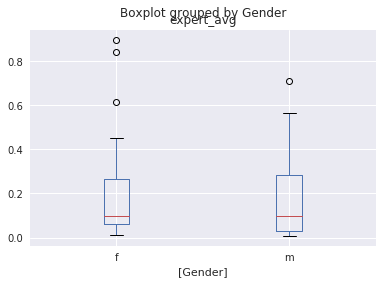

In [23]:
ci[['Gender', 'expert_avg']].boxplot(by='Gender', figsize=(6,4))
plt.show()

It appears it does not. Males have a slightly higher upper quartile, but nothing large enough to be significant.

Next, we plot some EEG channel features we extracted to see if any correlations exist. We randomly select the T5 and Fp2 channels. Note that all channels were plotted and analyzed, but for the sake of space we just include these two. All have rather similar features.

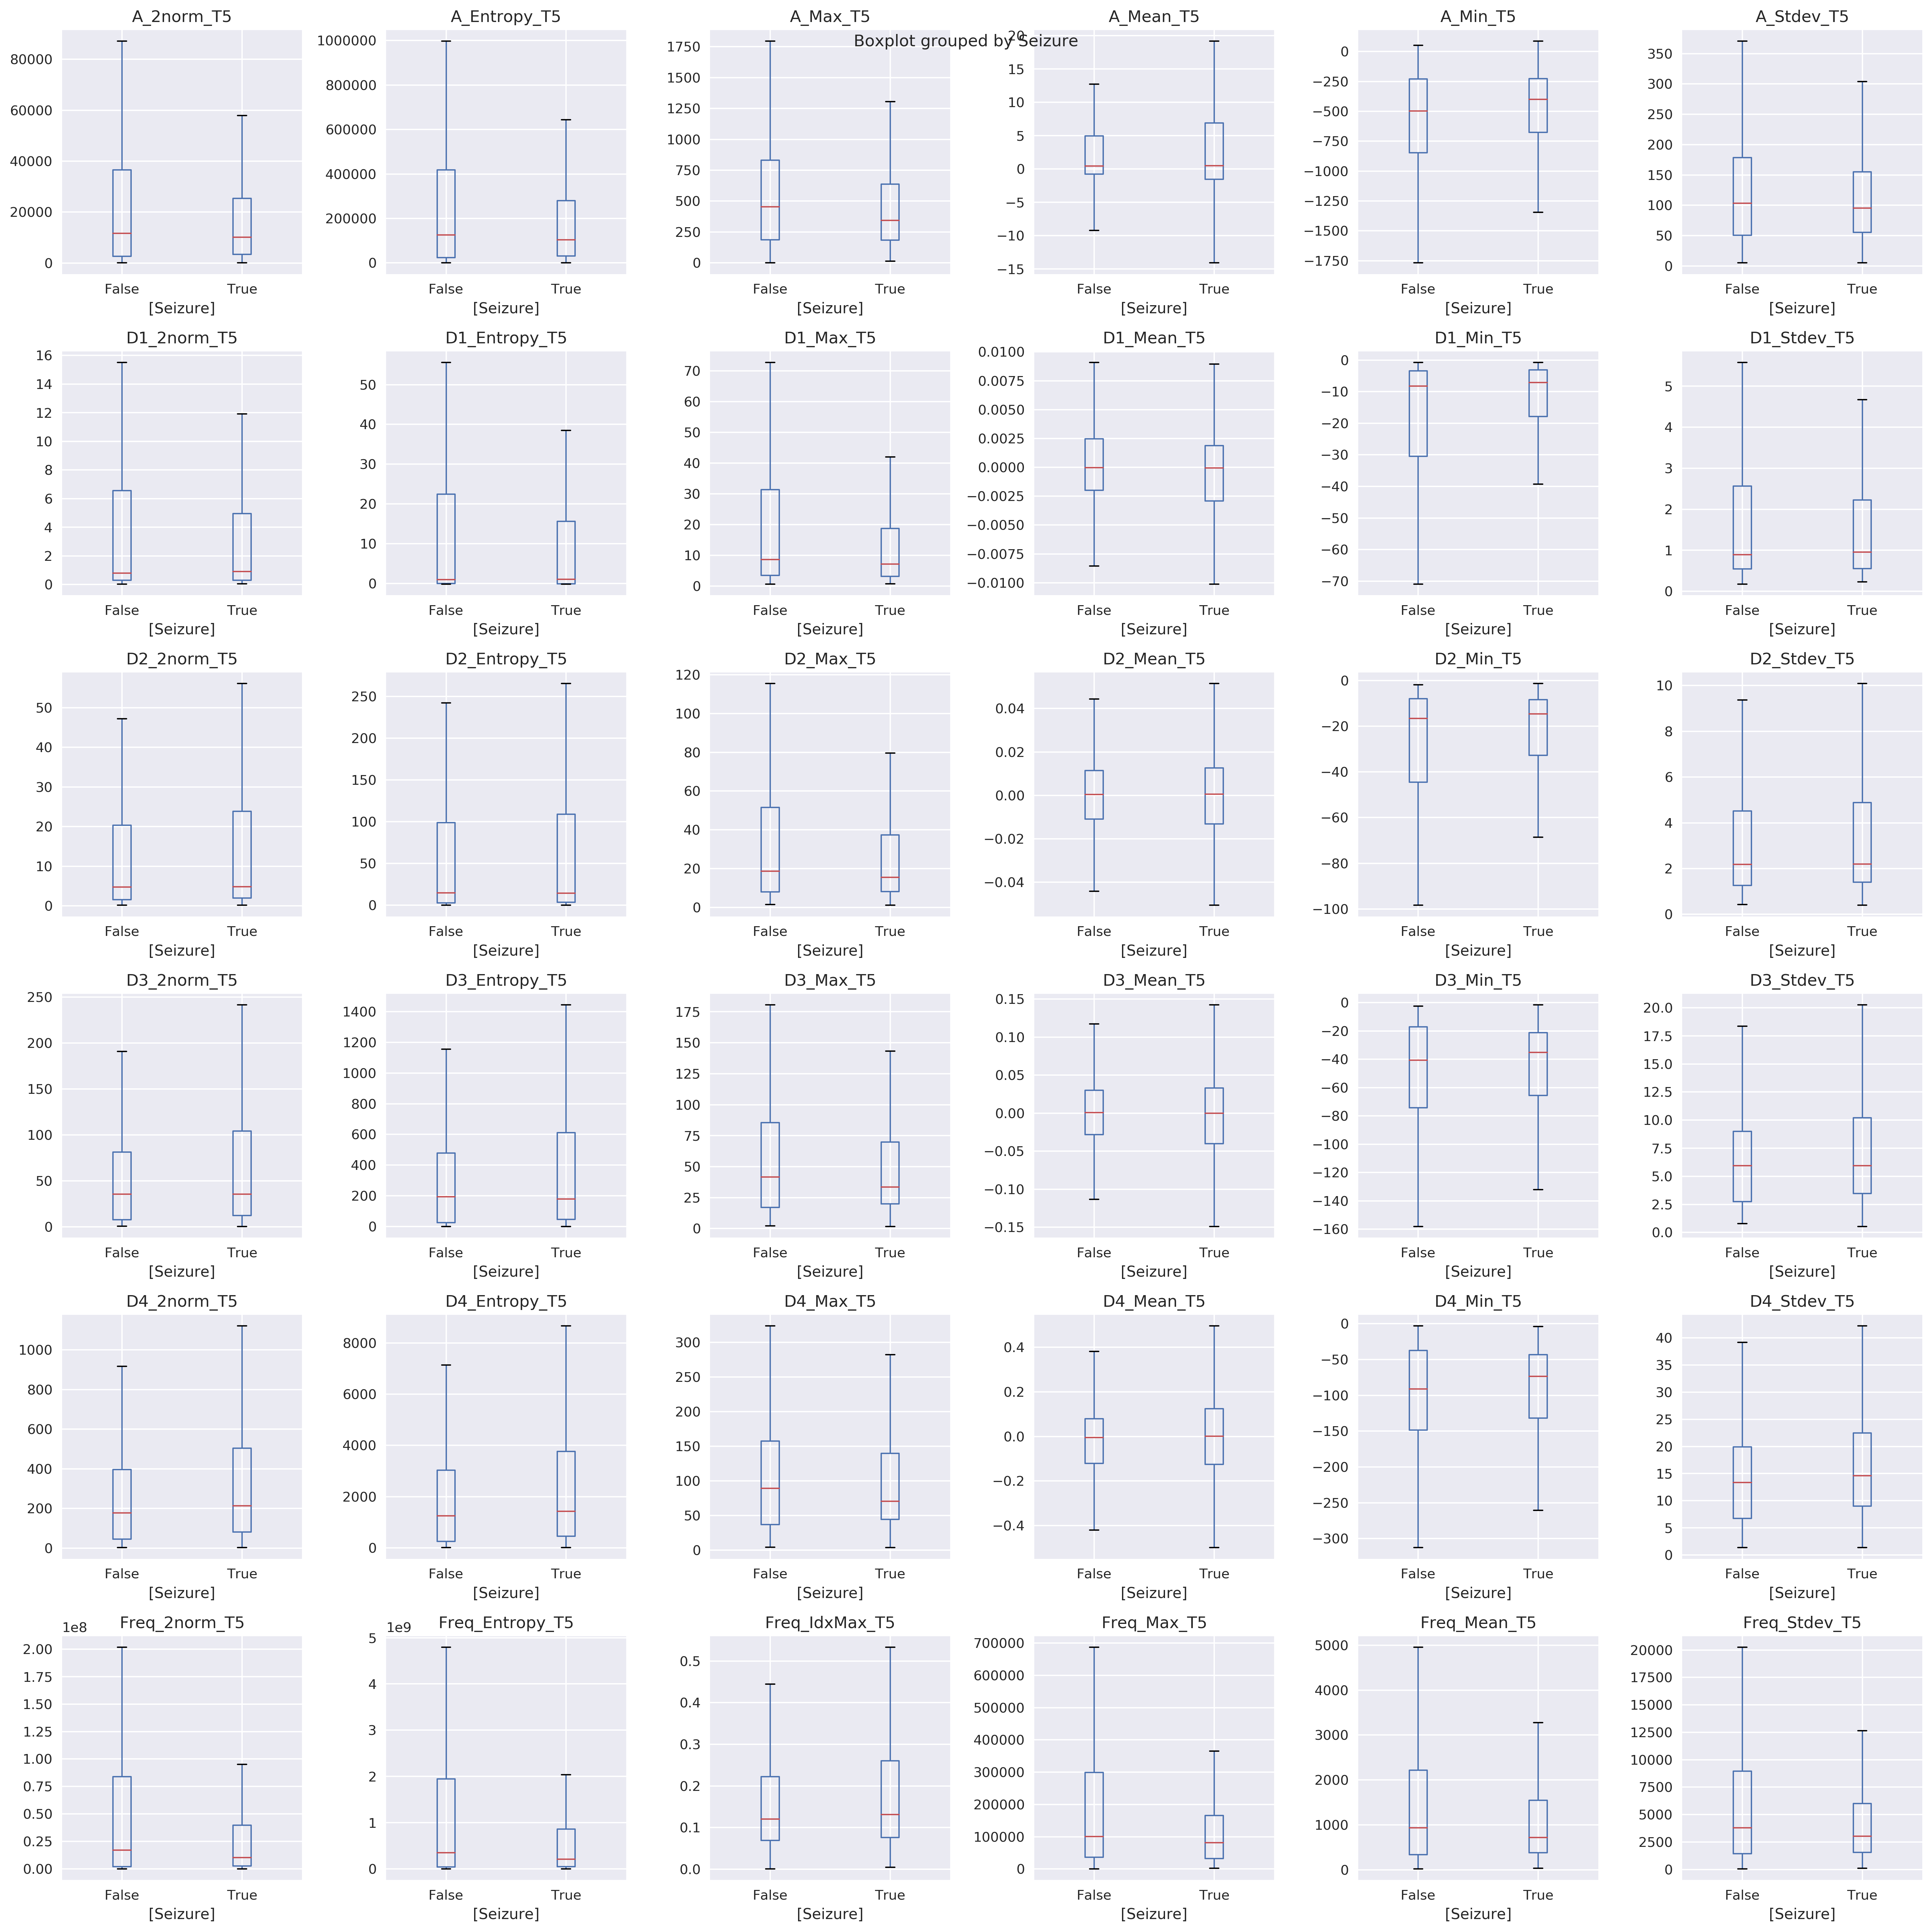

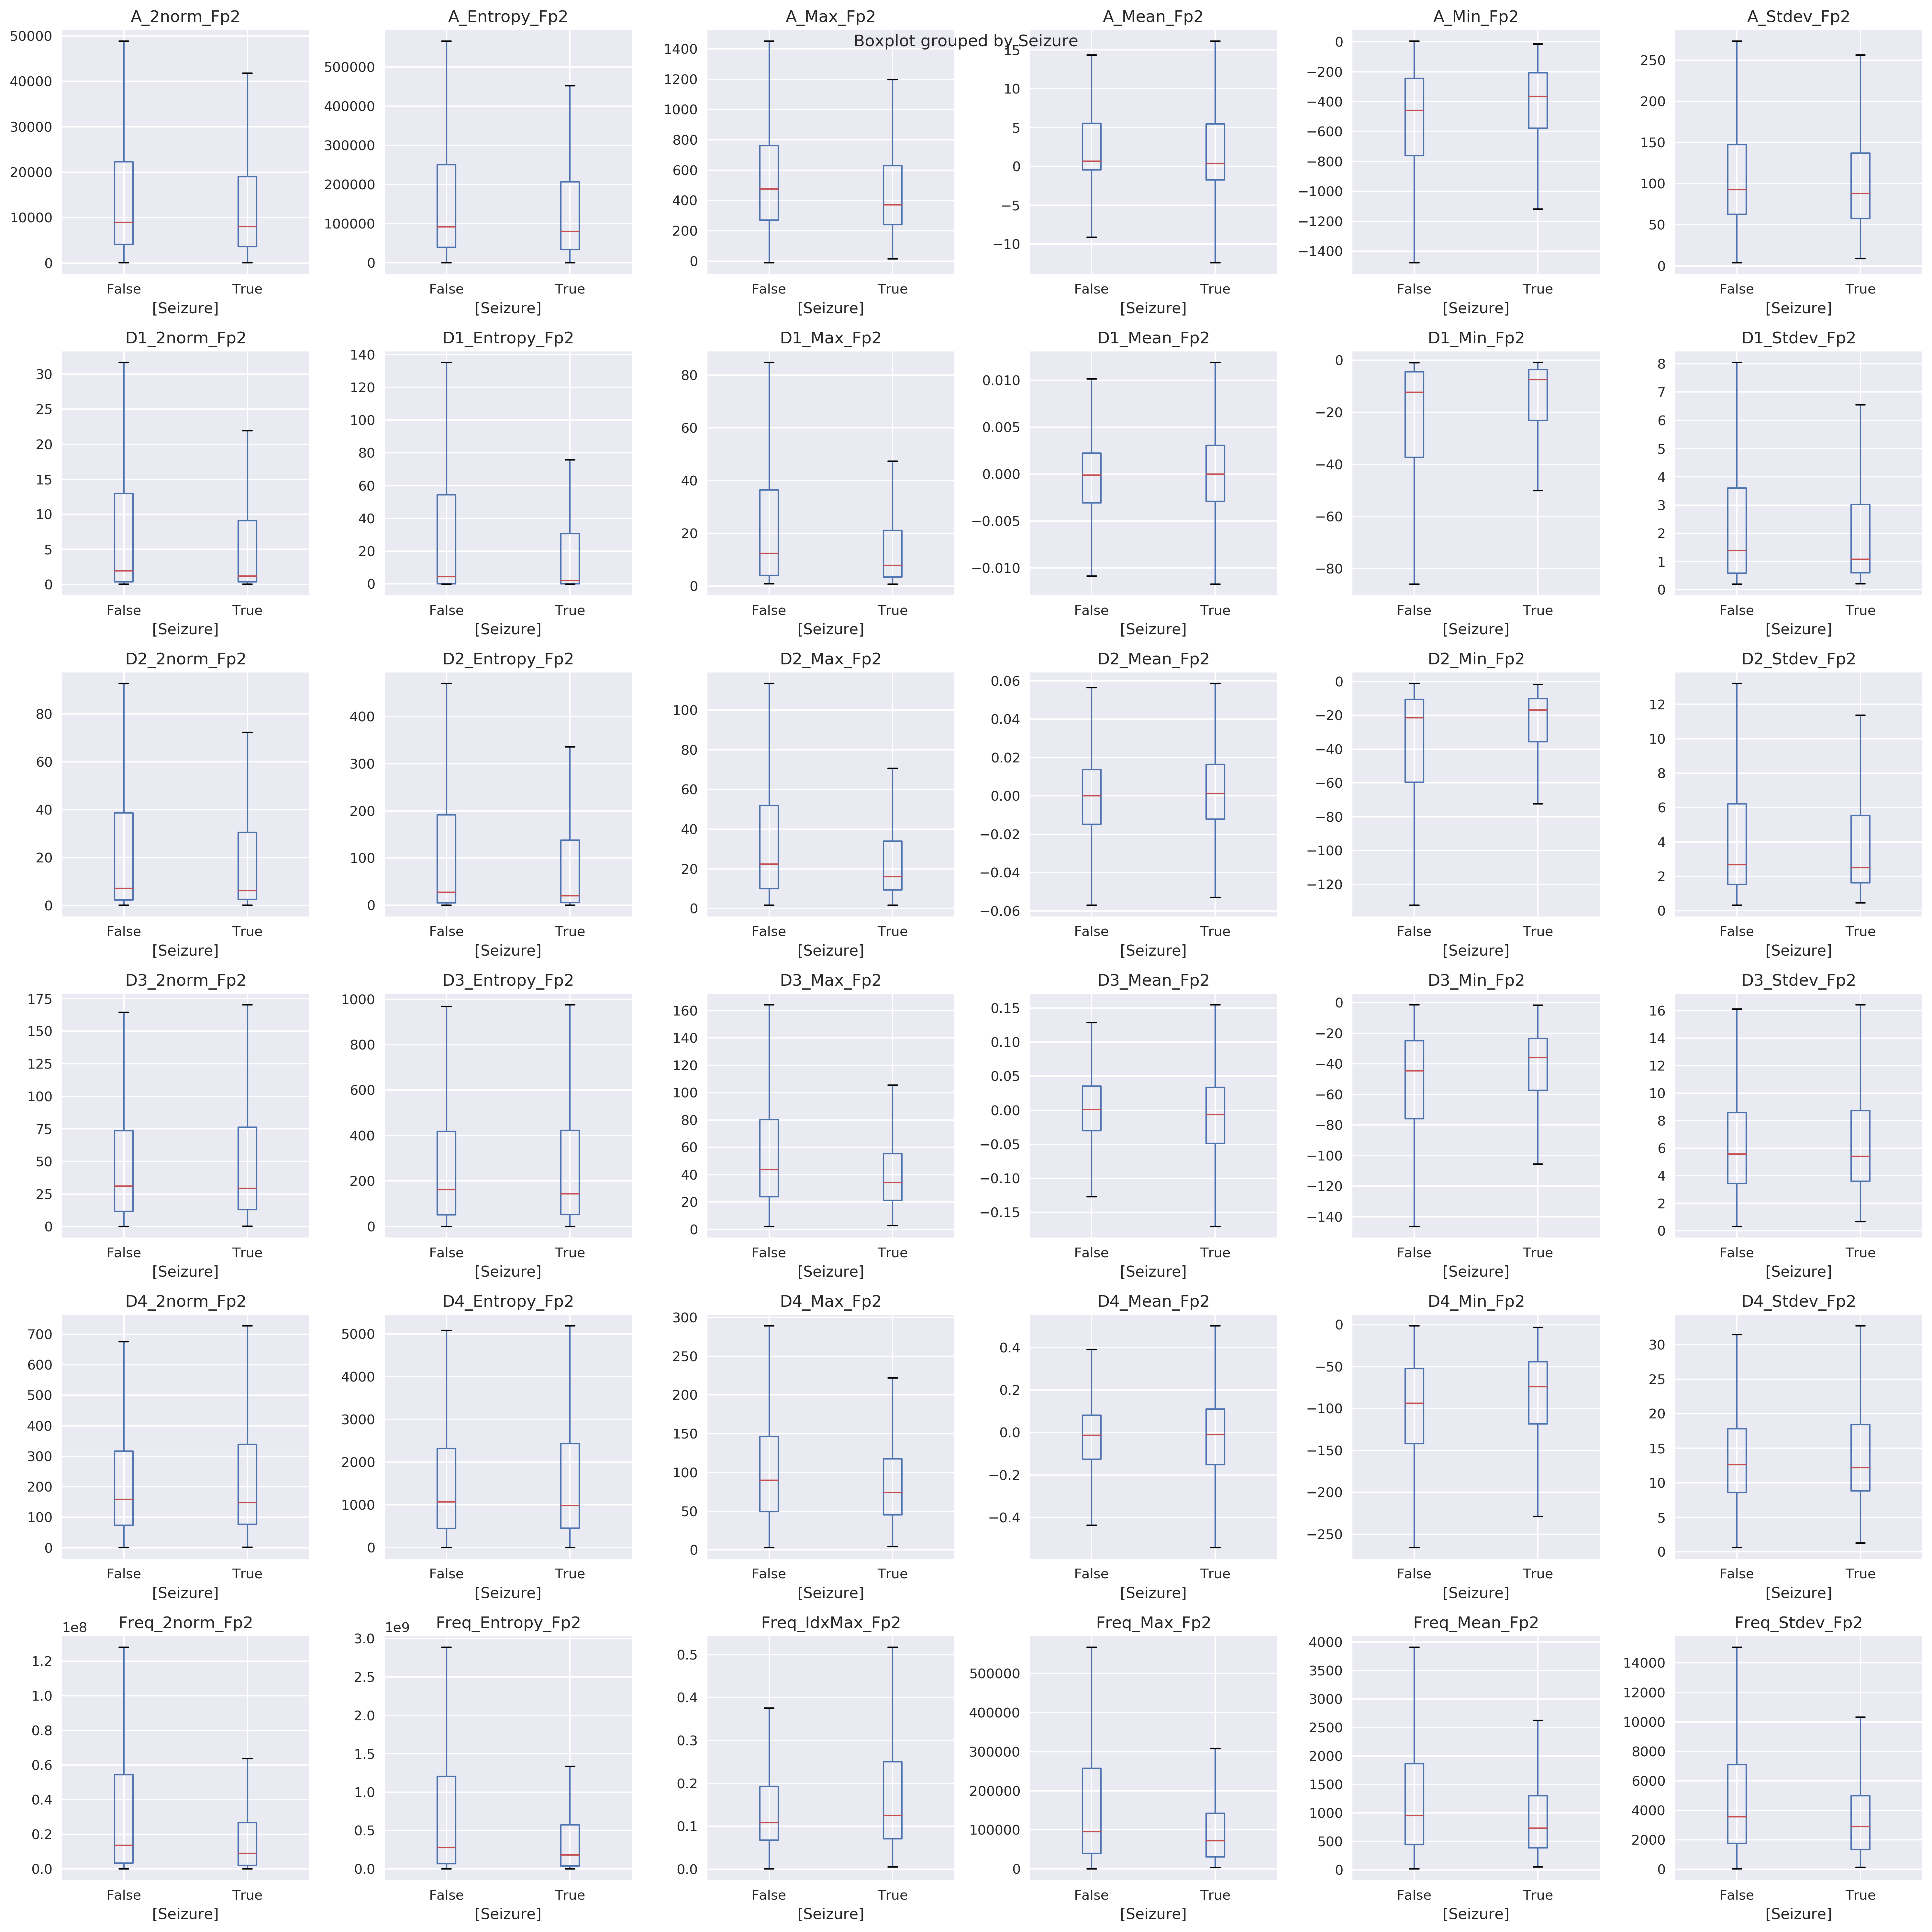

In [16]:
T5_cols = [col for col in df if (col.endswith("T5") or col == "Seizure")]
fig, ax_new = plt.subplots(6,6, sharey=False, figsize=(20,20))
df[T5_cols].boxplot(by='Seizure', ax=ax_new, showfliers=False)
plt.tight_layout()
plt.show()

Fp2_cols = [col for col in df if (col.endswith("Fp2") or col == "Seizure")]
fig, ax_new = plt.subplots(6,6, sharey=False, figsize=(20,20))
df[Fp2_cols].boxplot(by='Seizure', ax=ax_new, showfliers=False)
plt.tight_layout()
plt.show()

Notice that the Freq, A, D1, and D2 features seem to have the starkest contrast. This may imply that such a deep wavelet transform isn't necessary. Further, these differences in the frequency domain seem to imply that there is significantly less variance in frequency strength when seizures are occuring as noted by the lessed 2-norm, Max, Min, and Stdev. This may imply that the normal lower frequency content that occurs is lessened while higher frequencies are more common. Very similar trends can be seen in A, D1, and D2 features as well, likely due to similar causes.

We likewise analyze the Respitory Effort in an identical manner.

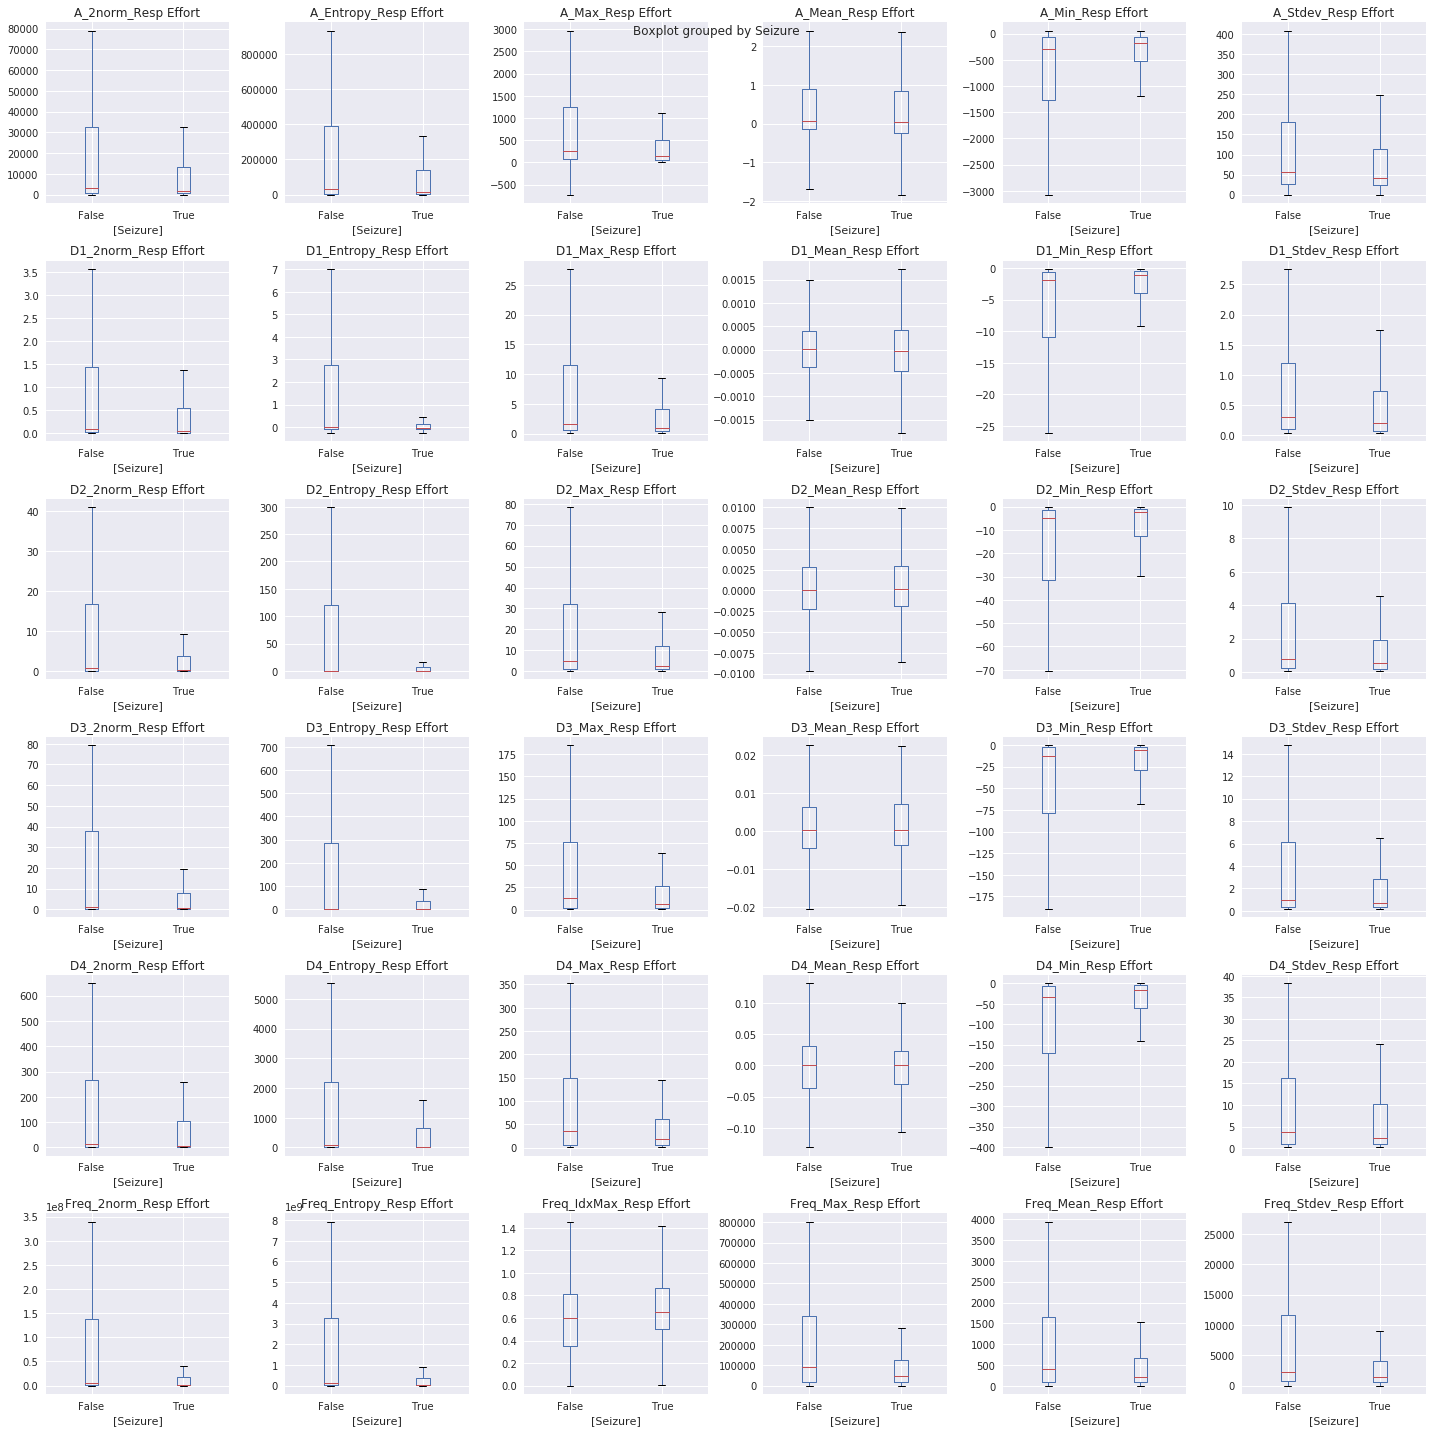

In [14]:
Resp_cols = [col for col in df if (col.endswith("Resp Effort") or col == "Seizure")]
fig, ax_new = plt.subplots(6,6, sharey=False, figsize=(20,20))
df[Resp_cols].boxplot(by='Seizure', ax=ax_new, figsize=(20,20), showfliers=False)
plt.tight_layout()
plt.show()

This is super interesting. It appears that while having a seizure the infant's breathing becomes more shallow - implied by the much smaller minimums, maximums, 2-norms, and entropies across all transform features, and much lower mean frequency. This doesn't necessarily mean that the same frequencies aren't present, just that they don't have anywhere near the same amplititude. In fact, notice the largest frequency still appears to be nearly the same, it just has a much lower amplitude.

# Conclusion

Even with relatively clean data coming in, there was significant work to do to clean both clinical information and to transform the EEG recordings into something useful. Once this was done, there were trends from which we can draw conclusions.

First, it appears that the neonates' brain must be developed enough to encounter frequent seizures, shown by many of the older neonates (both in GA and PMA) having a lot higher percentage of seizures than not.

Also, when seizures are occurring, it appears the low frequencies that are present in non-seizure time periods are greatly reduced, resulting in a much smaller 2-norm and entropy. In much literature about seizures and EEG recordings of adults, this is very common - it's believed that seizures are represented by high frequencies and lack of low frequencies, which is what we're seeing.

Further, the starkest contrast between seizure and non-seizure time periods is in respitory effort. As seen above, the present frequencies' amplititudes reduce significantly when a seizure is occurring and can be seen in both the Fourier and the Wavelet Transform. This is likely due to the shallower breathing of the neonates as they are struggling through the seizure. 

It is also difficult to analyze channels because seizures will happen in only one area of the brain - this means that the neonate may be having a seizure in one part of the brain while another part of the brain (aka another channel) may look completely normal. Since this data point will be in the "seizure" category, it skews the data to look more like a non-seizure. Ideally, we'd need to know exactly where the seizure is occuring or find some way around it. 

# References

[1] Nabeel Ahammad, Thasneem Fathima, and Paul Joseph, “Detection of Epileptic Seizure Event and Onset Using EEG,” BioMed Research International, vol. 2014, Article ID 450573, 7 pages, 2014.

[2] Nathan Stevenson, Karoliina Tapani, Leena Lauronen, & Sampsa Vanhatalo. (2018). A dataset of neonatal EEG recordings with seizures annotations [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1280684
